In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
df = pd.read_csv(df_path, sep="\t")

In [18]:
from eppi_text_classification import (
    get_features_and_labels,
    get_tfidf_and_names,
)

word_features, labels = get_features_and_labels(df)

tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [19]:
from eppi_text_classification import OptunaHyperparameterOptimisation

optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "XGBClassifier",
    n_trials_per_job=3,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
    # db_url=f"sqlite:////mnt/tmp/optuna.db", #Use this one on Azure
    db_url=None,
)

optimiser.delete_optuna_study("xgb_binary")
best_params = optimiser.optimise_hyperparameters(study_name="xgb_binary")

sqlite:////Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/optuna.db


[I 2024-09-10 16:14:43,431] A new study created in RDB with name: xgb_binary
[I 2024-09-10 16:14:48,248] Trial 1 finished with value: 0.9223833923837645 and parameters: {'reg_lambda': 0.00045890246204392305, 'reg_alpha': 0.0008391959630637035, 'learning_rate': 0.05907315289235327, 'max_depth': 1}. Best is trial 1 with value: 0.9223833923837645.
[I 2024-09-10 16:14:48,355] Trial 9 finished with value: 0.8891934461406305 and parameters: {'reg_lambda': 0.002758055982866364, 'reg_alpha': 12.561181129208403, 'learning_rate': 0.7902899914324945, 'max_depth': 1}. Best is trial 1 with value: 0.9223833923837645.
[I 2024-09-10 16:14:48,413] Trial 0 finished with value: 0.9009980231841622 and parameters: {'reg_lambda': 0.013321137409472121, 'reg_alpha': 16.506159799955217, 'learning_rate': 0.966740074329912, 'max_depth': 5}. Best is trial 1 with value: 0.9223833923837645.
[I 2024-09-10 16:14:48,785] Trial 3 finished with value: 0.9164143656494869 and parameters: {'reg_lambda': 0.00180001013718278

In [20]:
# FIT THE MODEL

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# model = XGBClassifier(**best_params)

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    colsample_bytree=1,
    n_jobs=-1,
    scale_pos_weight=42,
    reg_lambda=0.017636592766577953,
    reg_alpha=0.03834292094431529,
    learning_rate=0.4507787503025981,
    n_estimators=557,
    gamma=6.384905359051449e-10,
    max_depth=2,
)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=8
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=6.384905359051449e-10, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4507787503025981, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=557, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
# CREATE ROC CURVE TO SELECT THRESHOLD

from eppi_text_classification.predict import predict_scores
from eppi_text_classification.plotly_roc import plotly_roc

y_test_pred_probs = predict_scores(model, X_test)
plotly_roc(y_test, y_test_pred_probs)

In [22]:
# GET MODEL THRESHOLD FOR CHOSEN TPR, MAKE PREDICTIONS

from eppi_text_classification.predict import (
    get_raw_threshold,
    raw_threshold_predict,
)


threshold = get_raw_threshold(model, X_test, y_test, target_tpr=1)

y_test_pred = raw_threshold_predict(model, X_test, threshold)
y_train_pred = raw_threshold_predict(model, X_train, threshold)

In [23]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

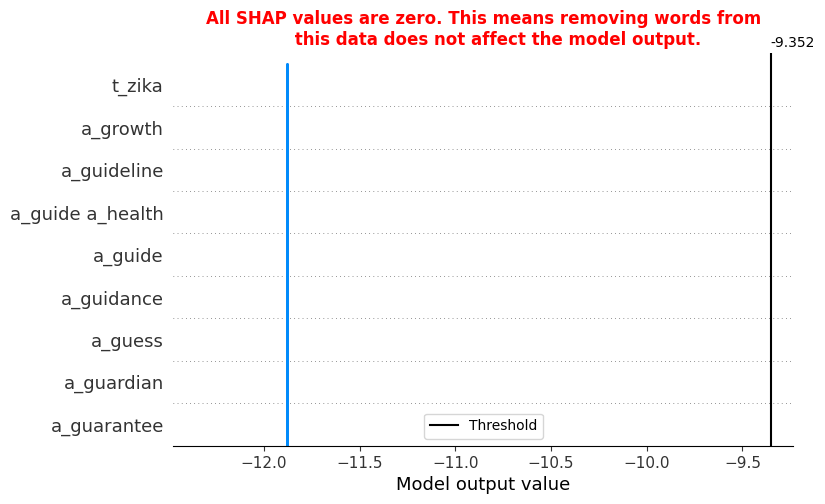

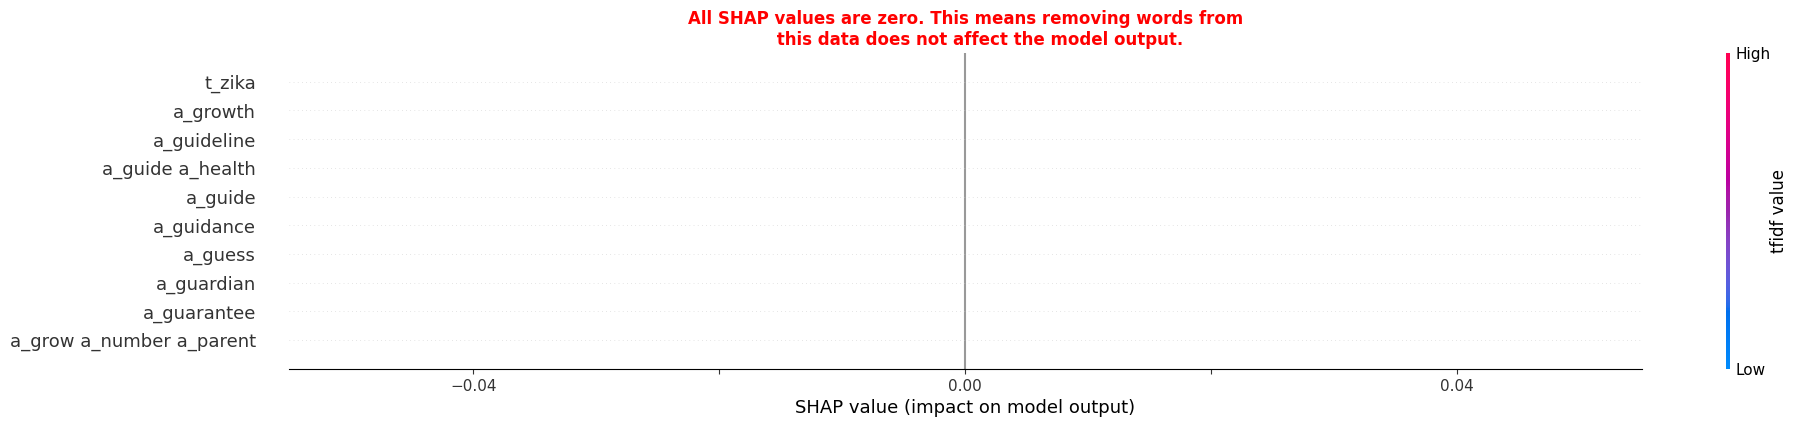

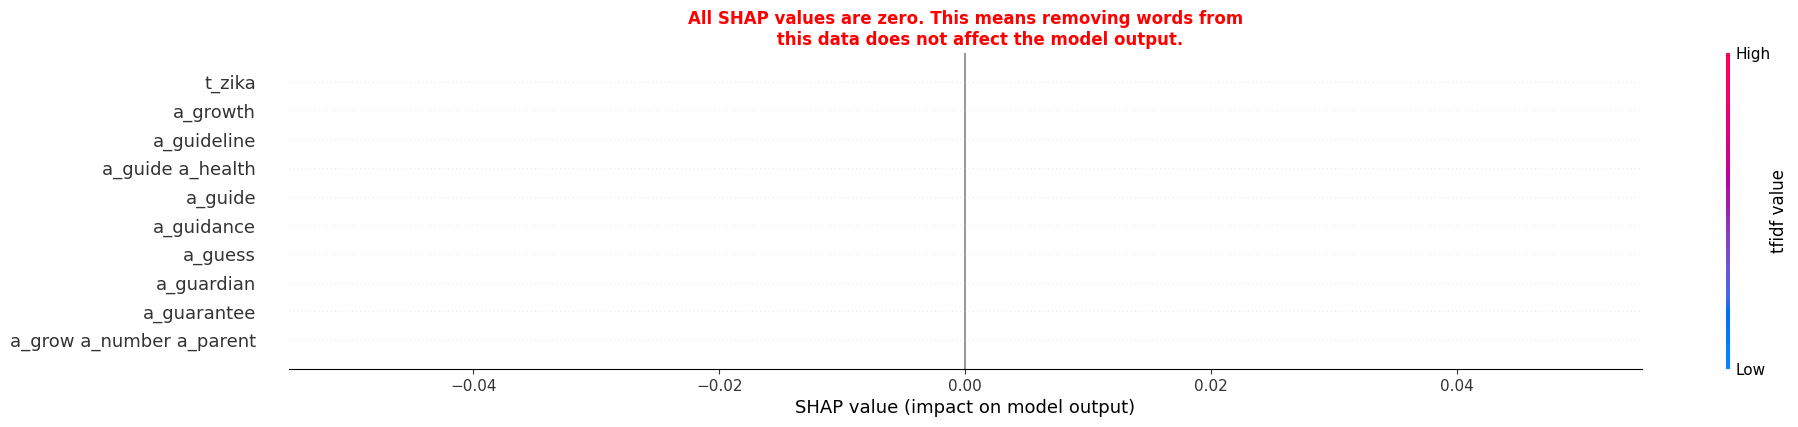

In [45]:
# EXPLAIN THE MODEL
import warnings

from eppi_text_classification.shap_plotter import ShapPlotter

L = [
    2,
    8,
    66,
    100,
    116,
    121,
    139,
    163,
    173,
    189,
    191,
    213,
    255,
    268,
    304,
    331,
    352,
    366,
]

shap_plotter = ShapPlotter(
    model,
    X_test[L],
    feature_names,
)
decision_plot = shap_plotter.decision_plot(
    threshold=threshold,
    num_display=10,
    log_scale=False,
)
decision_plot.show()
dot_plot = shap_plotter.dot_plot(num_display=10)
dot_plot.show()
bar_plot = shap_plotter.bar_chart(num_display=10)
dot_plot = shap_plotter.dot_plot(num_display=10, log_scale=False)
dot_plot.show()

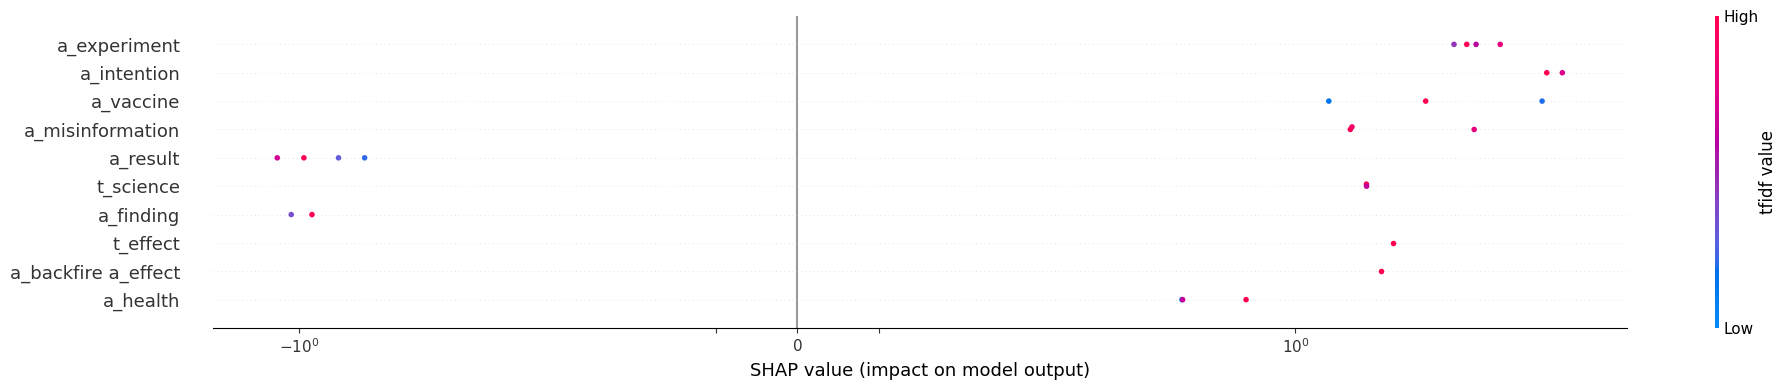

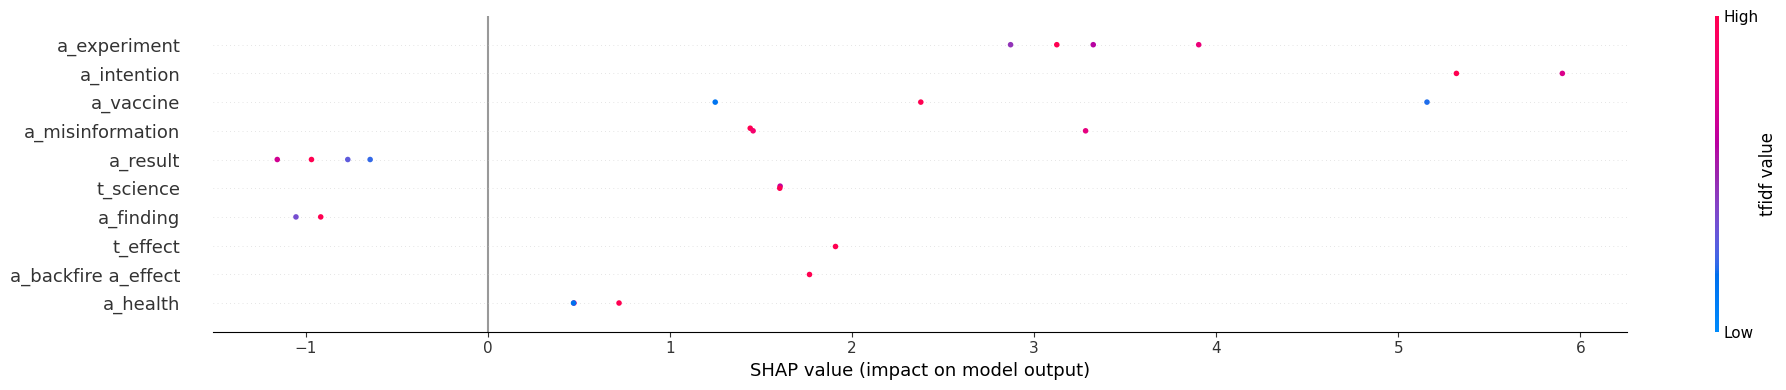

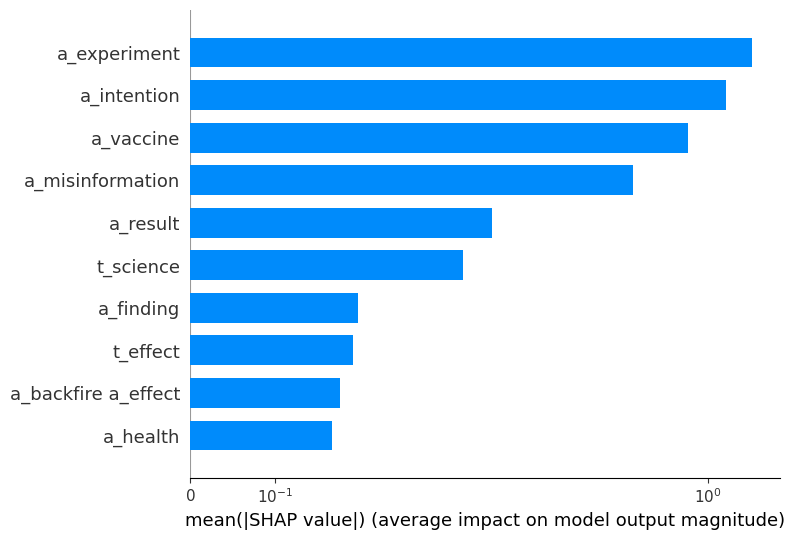

In [26]:
# EXLPAIN THE MODEL

from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(
    model,
    X_test[:10],
    feature_names,
)

dot_plot = shap_plotter.dot_plot(num_display=10)
dot_plot.show()
dot_plot = shap_plotter.dot_plot(num_display=10, log_scale=False)
dot_plot.show()
bar_plot = shap_plotter.bar_chart()
bar_plot.show()

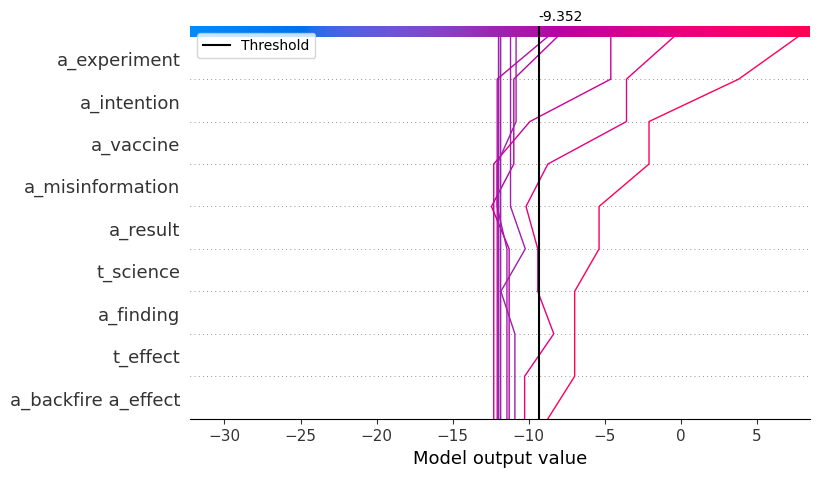

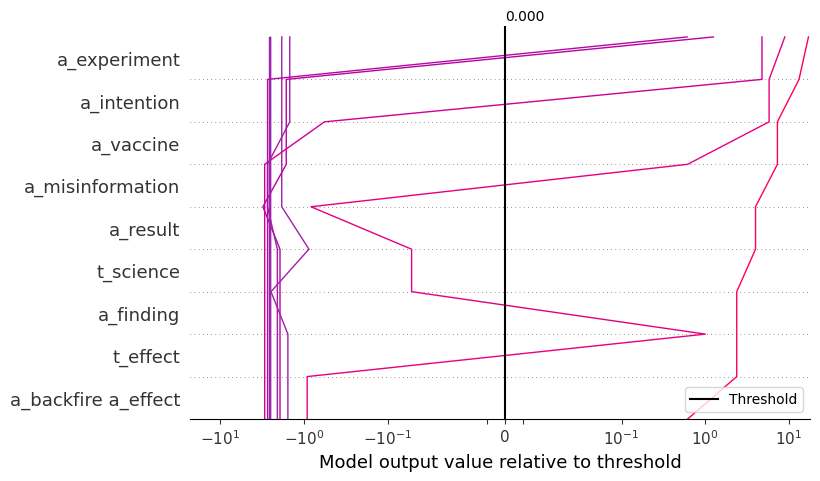

In [31]:
# MAKE THE DECISION PLOTS

from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(
    model,
    X_test[:10],
    feature_names,
)
decision_plot = shap_plotter.decision_plot(threshold=threshold, num_display=10)
decision_plot.show()
decision_plot = shap_plotter.decision_plot(
    threshold=threshold, num_display=10, log_scale=True
)
decision_plot.show()

Truth: 0
Prediction: 1
Shap value: -11.879698753356934
Prediction score: -8.105419158935547


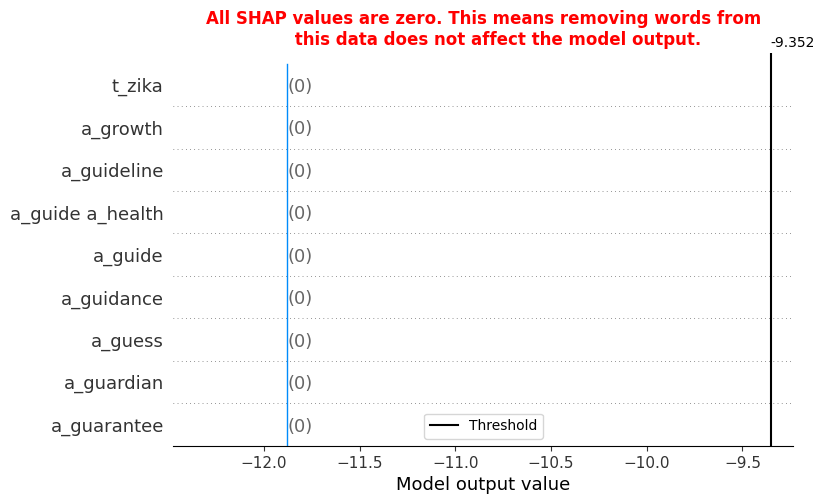

Truth: 0
Prediction: 1
Shap value: -11.879698753356934
Prediction score: -0.4430283010005951


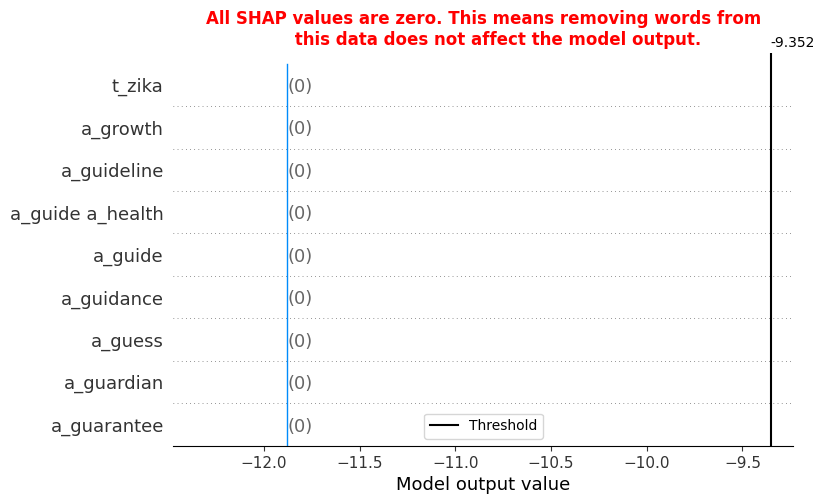

Truth: 0
Prediction: 0
Shap value: -11.879698753356934
Prediction score: -11.879698753356934


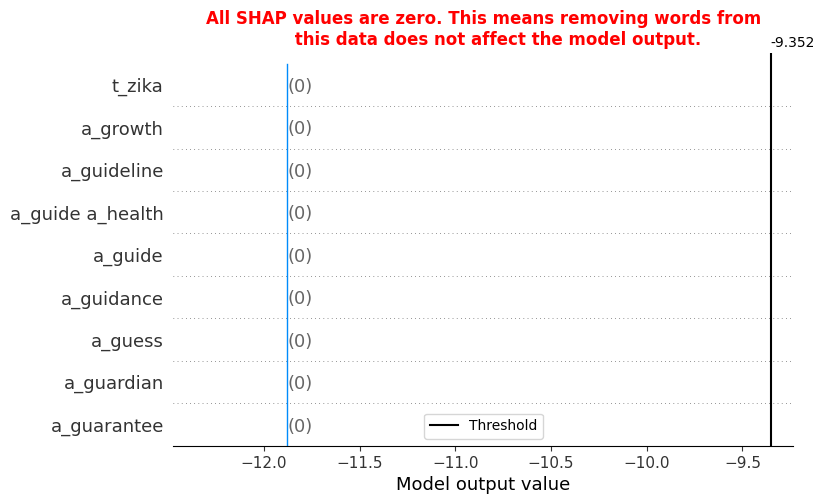

Truth: 0
Prediction: 0
Shap value: -11.879698753356934
Prediction score: -11.19356918334961


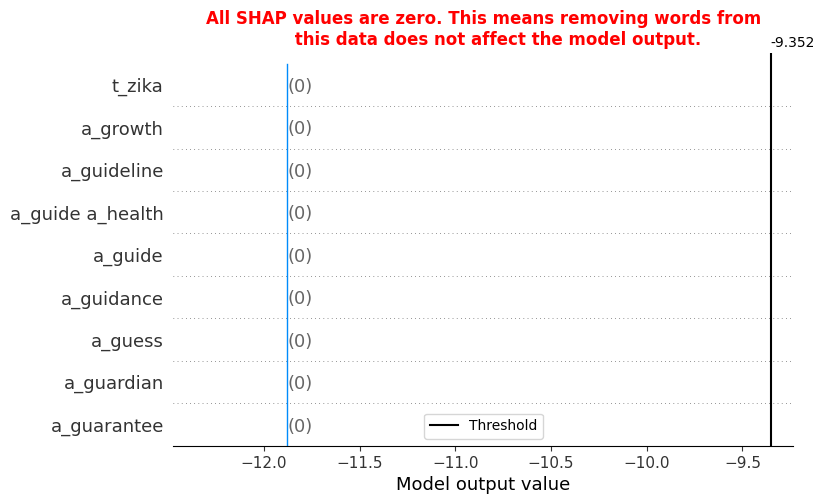

Truth: 0
Prediction: 0
Shap value: -11.879698753356934
Prediction score: -11.985177993774414


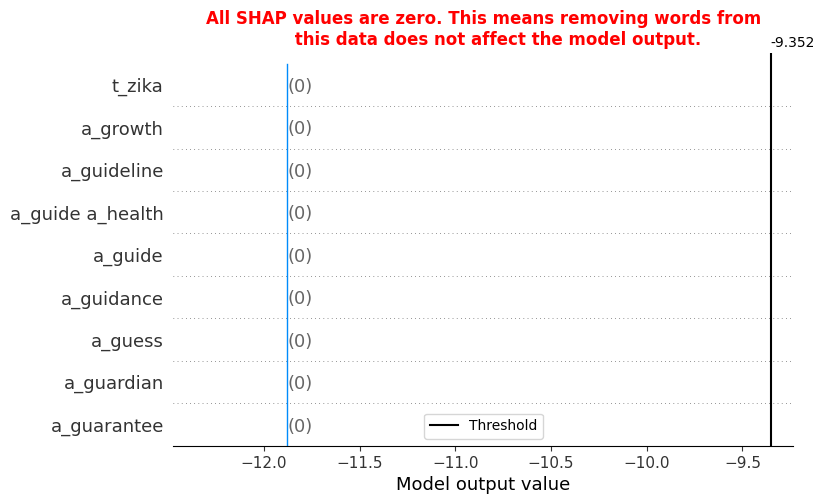

In [46]:
import numpy as np

for i in range(5):
    print(f"Truth: {y_test[i]}")
    print(f"Prediction: {raw_threshold_predict(model, X_test, threshold)[i]}")
    print(
        f"Shap value: {shap_plotter.shap_values[i].sum() + shap_plotter.expected_value}"
    )
    print(f"Prediction score: {predict_scores(model, X_test)[i]}")
    decision_plot = shap_plotter.single_decision_plot(
        threshold=threshold, index=i, num_display=10, log_scale=False
    )
    decision_plot.show()